##  Importing data and libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import keras
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from livelossplot import PlotLossesKeras
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
%matplotlib inline

Using TensorFlow backend.


In [51]:
labels = pd.read_csv('train_labels.csv.zip')
train_path = '/home/karalayd/kaggle/cancer/train/'
test_path = '/home/karalayd/kaggle/cancer/test/'
test_path_2 = '/home/karalayd/kaggle/cancer/test2/'

In [4]:
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

220025
57458


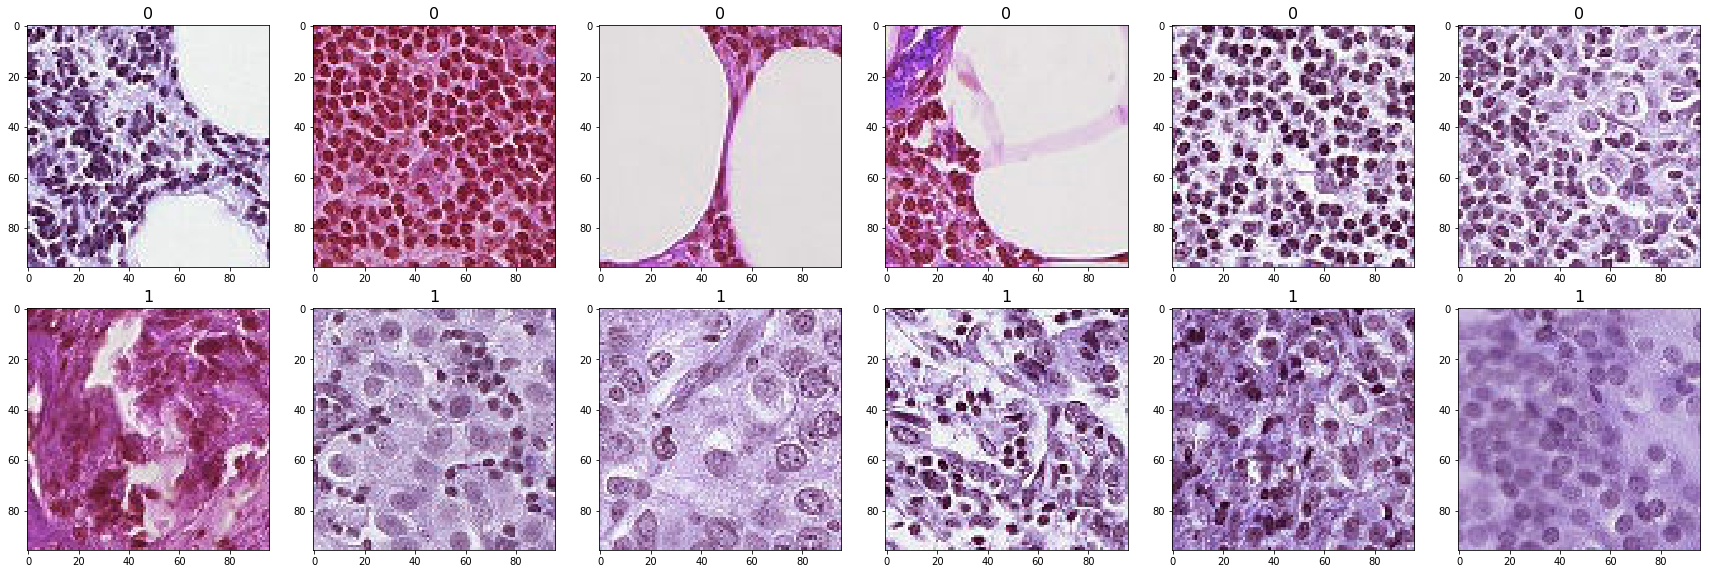

In [4]:
#Визуализируем данные:
categories = (labels.groupby(['label'])['label'].nunique()).index
f, ax = plt.subplots(nrows=len(categories),ncols=6, 
                     figsize=(4*6,4*len(categories))) 
for i, cat in enumerate(categories):
    sample = labels[labels['label']==cat].sample(6)
    for j in range(0,6):
        file = TRAIN_PATH + sample.iloc[j]['id'] + '.tif'
        im=cv2.imread(file)
        ax[i, j].imshow(im, resample=True, cmap='gray')
        ax[i, j].set_title(cat, fontsize=16)  
plt.tight_layout()
plt.show()

## Class balancing

In [5]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [7]:
count_class_0, count_class_1 = labels['label'].value_counts()
df_class_0 = labels[labels['label'] == 0]
df_class_1 = labels[labels['label'] == 1]

Random under-sampling:
1    89117
0    89117
Name: label, dtype: int64


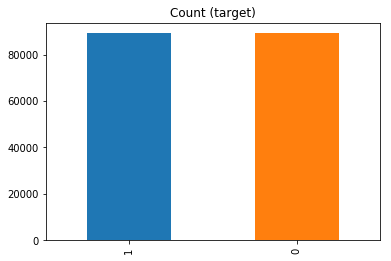

In [8]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under['label'].value_counts())

df_train_under['label'].value_counts().plot(kind='bar', title='Count (target)')

## Creating training, validation, test sets

In [16]:
y = df_train_under['label']
train, val = train_test_split(df_train_under, test_size=0.10, random_state=101, stratify=y)
train, test = train_test_split(train, test_size=0.10, random_state=7)
print(train.shape)
print(val.shape)
print(test.shape)

(144369, 2)
(17824, 2)
(16041, 2)


In [17]:
train['label'].value_counts()

1    72274
0    72095
Name: label, dtype: int64

In [18]:
val['label'].value_counts()

1    8912
0    8912
Name: label, dtype: int64

In [29]:
train_list_0 = list(train['id'][train['label']==0])
train_list_1 = list(train['id'][train['label']==1])
val_list_0 = list(val['id'][val['label']==0])
val_list_1 = list(val['id'][val['label']==1])
test_list_0 = list(test['id'][val['label']==0])
test_list_1 = list(test['id'][val['label']==1])

In [3]:
train_data_dir = '/home/karalayd/kaggle/cancer/model/train'
validation_data_dir = '/home/karalayd/kaggle/cancer/model/val'
test_data_dir = '/home/karalayd/kaggle/cancer/model/test'

In [4]:
val_path_0 = '/home/karalayd/kaggle/cancer/model/val/0'
val_path_1 = '/home/karalayd/kaggle/cancer/model/val/1'
train_path_0 = '/home/karalayd/kaggle/cancer/model/train/0'
train_path_1 = '/home/karalayd/kaggle/cancer/model/train/1'

In [5]:
test_path_0 = '/home/karalayd/kaggle/cancer/model/test/0'
test_path_1 = '/home/karalayd/kaggle/cancer/model/test/1'

In [25]:
os.mkdir(train_data_dir)
os.mkdir(validation_data_dir)
os.mkdir(test_data_dir)
os.mkdir(val_path_0)
os.mkdir(val_path_1)
os.mkdir(train_path_0)
os.mkdir(train_path_1)
os.mkdir(test_path_0)
os.mkdir(test_path_1)

In [47]:
def image_move(image_list, path_to):
    """Function moves images from one directory to another."""
    for i in image_list:
        shutil.move(os.path.join(train_path + '/' + i + '.tif'), os.path.join(path_to + '/' + i + '.tif'))

In [34]:
image_move(val_list_1, val_path_1)
image_move(val_list_0, val_path_0)
image_move(train_list_0, train_path_0)
image_move(train_list_1, train_path_1)
image_move(test_list_0, test_path_0)
image_move(test_list_1, test_path_1)

In [45]:
def convert_tif_to_jpg(path):
    """Function converts tif images to jpg format, makes duplicates."""
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
                if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                    print("A jpeg file already exists for %s" % name)
                else:
                    outfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
                    im = Image.open(os.path.join(root, name))
                    print("Generating jpeg for %s" % name)
                    im.thumbnail(im.size)
                    im.save(outfile, "JPEG", quality=100)

In [42]:
convert_tif_to_jpg(val_path_1)
convert_tif_to_jpg(val_path_0)
convert_tif_to_jpg(train_path_0)
convert_tif_to_jpg(train_path_1)
convert_tif_to_jpg(test_path_0)
convert_tif_to_jpg(test_path_1)
convert_tif_to_jpg(test_path)

Generating jpeg for ca807086e66f61d37ae29f6c0841b7dd84f893e2.tif
Generating jpeg for 53a50f470d32c74980deffeb33da4d92916a8d80.tif
Generating jpeg for e339c63f7eaa14265d2a0c07441e5d6ed09e63d9.tif
Generating jpeg for ebb19c531ac3ec58b8b982add07f87baf3bfd1fb.tif
Generating jpeg for 8881cbad00519d13c092965f88997893b491cb43.tif
Generating jpeg for 11bddc21a114a0bf429fe52e5bdb025160539941.tif
Generating jpeg for d2274e04d1fb99f15051d689dce21fcae547e691.tif
Generating jpeg for 87e2f6347c170772bf4a68b102f8757356539ab4.tif
Generating jpeg for 37851884accf0e157a1c0b03f376363fd4bd9fe8.tif
Generating jpeg for 33ff9f03e150987e66da47ac1363765fc1708c03.tif
Generating jpeg for 160344d90914f57f05051923d5ae22cde23d3535.tif
Generating jpeg for bc61ee3d5238c7c3ecb4323c176d2bd355747071.tif
Generating jpeg for f61d73ae2b38d1b41ca203f326605955bd6d847a.tif
Generating jpeg for 4a5d7a794effc2a88b29d0eb40538f2860992e58.tif
Generating jpeg for 0e3112e0640a6125d4e09324da94f01c11ad9600.tif
Generating jpeg for db1ff

## Bulding model

In [42]:
input_shape = (96, 96, 3)
num_classes = 2
batch_size = 32
epochs = 10
nb_train_samples =  144369
nb_validation_samples = 17823
epochs = 10
batch_size = 32
img_width, img_height = 96, 96

In [30]:
model = Sequential() 
model.add(Conv2D(32, (2, 2), input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(32, (2, 2))) 
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(64, (2, 2))) 
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1)) 
model.add(Activation('sigmoid')) 

In [31]:
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9)

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 95, 95, 32)        416       
_________________________________________________________________
batch_normalization_7 (Batch (None, 95, 95, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 95, 95, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 32)        4128      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 46, 46, 32)        0         
__________

In [33]:
train_datagen = ImageDataGenerator( 
    rescale=1./255, 
    rotation_range=8, 
    width_shift_range=0.08,
    shear_range=0.3,
    height_shift_range=0.08,
    zoom_range=0.08, 
    horizontal_flip = True) 

In [34]:
validation_datagen = ImageDataGenerator(rescale=1./255) 

In [49]:
train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, class_mode ='binary') 

Found 144369 images belonging to 2 classes.


In [36]:
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(img_width, img_height), 
                                                        batch_size=batch_size, class_mode ='binary')

Found 17824 images belonging to 2 classes.


In [37]:
def my_generator(generator):
    """Function helps to avoid problems when training the neural network due to corrupted images."""
    while True:
        try:
            data, labels = next(generator)
            yield data, labels
        except:
            pass

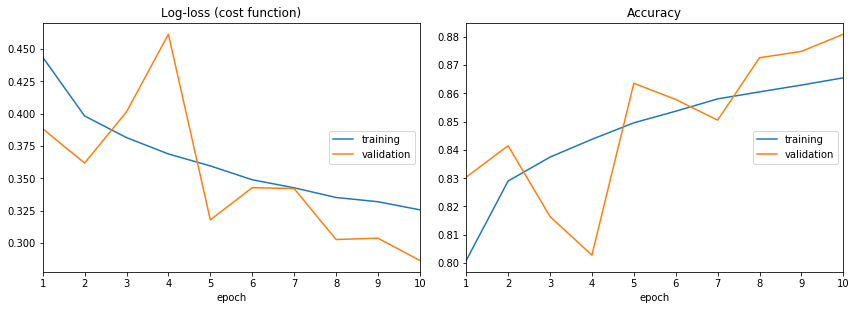

Log-loss (cost function):
training   (min:    0.326, max:    0.444, cur:    0.326)
validation (min:    0.286, max:    0.462, cur:    0.286)

Accuracy:
training   (min:    0.801, max:    0.866, cur:    0.866)
validation (min:    0.803, max:    0.881, cur:    0.881)
Epoch 00010: val_acc improved from 0.87489 to 0.88096, saving model to histopathologic_cancer_detector.h5
4511/4511 [==============================] - 346s 77ms/step - loss: 0.3256 - acc: 0.8655 - val_loss: 0.2864 - val_acc: 0.8810


Exception ignored in: <generator object my_gen at 0x7f9607c75b48>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f960574baf0>
RuntimeError: generator ignored GeneratorExit


In [38]:
history = model.fit_generator(my_generator(train_generator), 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = my_generator(validation_generator), 
    validation_steps = nb_validation_samples // batch_size,
    verbose=1,
    callbacks=[PlotLossesKeras(),
               ModelCheckpoint('histopathologic_cancer_detector.h5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True,
                               mode='max'),
               CSVLogger('training_logs.csv',
                         append=False,
                         separator=';')]) 

## Model evaluation

In [40]:
from keras.models import load_model
model = load_model('histopathologic_cancer_detector.h5')

Found 16041 images belonging to 2 classes.
502/502 [==============================] - 12s 25ms/step


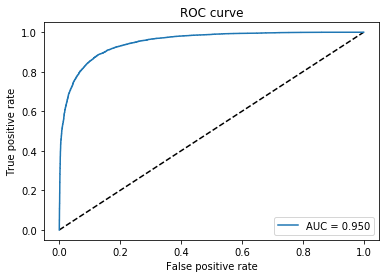

In [43]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                                  target_size=(img_width, img_height),
                                                                                  batch_size=batch_size,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('roc.png', bbox_inches='tight')
plt.show()

## Making predictions

In [56]:
testing_files = [test_path_2 + i for i in os.listdir(test_path_2)]
submission = pd.DataFrame()
for index in range(0, len(testing_files), 5000):
    data_frame = pd.DataFrame({'path': testing_files[index:index+5000]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[6].split(".")[0])
    data_frame['image'] = data_frame['path'].map(cv2.imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
submission.to_csv("kaggle_submission.csv", index=False, header=True)